  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



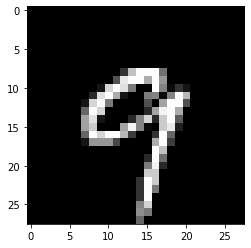

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms 
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline


is_cuda=False
if torch.cuda.is_available():
    is_cuda = True  # Use GPU

transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))]) # 이미지를 텐서로 변환 후 normalize
train_dataset = datasets.MNIST('data/',train=True,transform=transformation,download=True) # Mnist data
test_dataset = datasets.MNIST('data/',train=False,transform=transformation,download=True)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True) #batch size 32로 data loading
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)
sample_data = next(iter(train_loader)) # set next data for sample

def plot_img(image):
    image = image.numpy()[0] # 이미지를 numpy로 저장
    mean = 0.1307
    std = 0.3081
    image = ((mean * image) + std) 
    plt.imshow(image,cmap='gray') #gray scale로 출력

plot_img(sample_data[0][2])

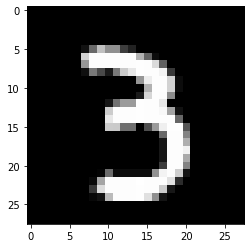

In [ ]:
plot_img(sample_data[0][1])

In [ ]:
class Net(nn.Module): 
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) 
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) 
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x,p=0.1, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

model = Net() 
if is_cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(),lr=0.01) 
data , target = next(iter(train_loader))
output = model(Variable(data.cuda()))
print("output : ", output.size())
print("target : ", target.size())

output :  torch.Size([32, 10])
target :  torch.Size([32])


In [ ]:
def fit(epoch,model,data_loader,phase='training',volatile=False): 
    if phase == 'training':
        model.train()

    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0

    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target) 
        if phase == 'training':
            optimizer.zero_grad() 
        output = model(data)
        loss = F.nll_loss(output,target)

        running_loss += F.nll_loss(output,target,size_average=False).data
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum() 
        if phase == 'training':
            loss.backward() 
            optimizer.step()

    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)

    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}') 
    return loss, accuracy

train_losses , train_accuracy = [],[] 
val_losses , val_accuracy = [],[]

for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_loader,phase='training') 
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation') 
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy) 
    val_losses.append(val_epoch_loss) 
    val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is  0.61 and training accuracy is 48548/60000     80.91
validation loss is  0.14 and validation accuracy is 9566/10000     95.66
training loss is  0.19 and training accuracy is 56639/60000      94.4
validation loss is 0.091 and validation accuracy is 9709/10000     97.09
training loss is  0.15 and training accuracy is 57446/60000     95.74
validation loss is 0.073 and validation accuracy is 9776/10000     97.76
training loss is  0.13 and training accuracy is 57818/60000     96.36
validation loss is  0.06 and validation accuracy is 9808/10000     98.08
training loss is  0.11 and training accuracy is 58050/60000     96.75
validation loss is 0.051 and validation accuracy is 9835/10000     98.35
training loss is   0.1 and training accuracy is 58149/60000     96.92
validation loss is 0.056 and validation accuracy is 9815/10000     98.15
training loss is 0.096 and training accuracy is 58318/60000      97.2
validation loss is 0.045 and validation accuracy is 9855/10000     98.55

In [ ]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss') 
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss') 
plt.legend()

In [ ]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy') 
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy') 
lt.legend()